<a href="https://colab.research.google.com/github/sancarhacer/MachineLearning/blob/main/18_LightGBMClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


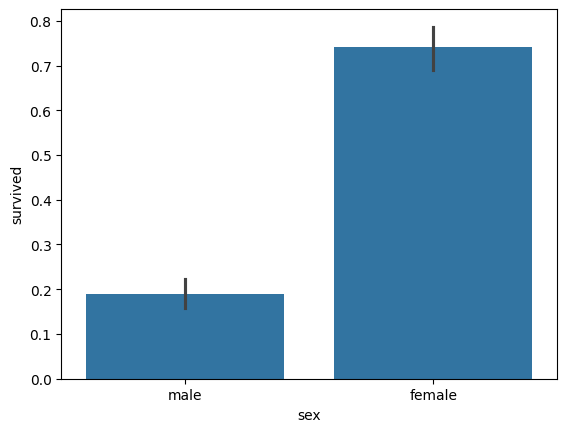

In [3]:
# let's do some eda
sns.barplot(x='sex', y='survived', data=df)
plt.show()

In [4]:
df['sex'].value_counts()

,count
sex,
male,577
female,314


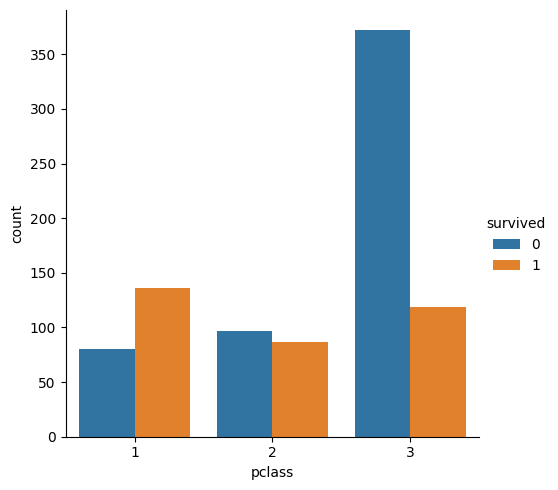

In [5]:
#females are prioritized in the evacuation
sns.catplot(x='pclass', hue='survived', kind='count', data=df)
plt.show()

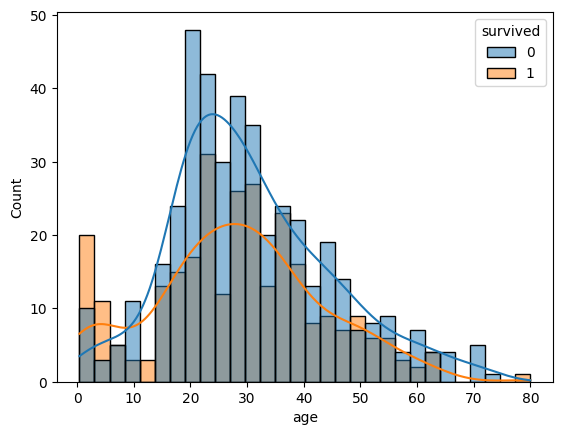

In [6]:
# if we look at the percentage of survived/not survived wiwthin class
# clearly, 1st and 2nd classes are luckier than 3rd class
sns.histplot(data=df, x='age', hue='survived', bins=30, kde=True)
plt.show()

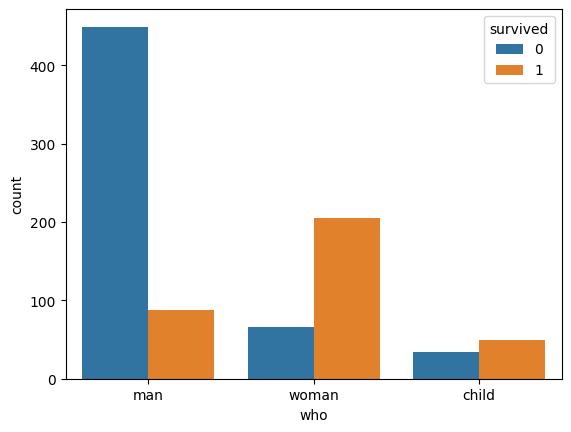

In [7]:
# children seem to be prioritized during evacuation
sns.countplot(x='who', hue='survived', data=df)
plt.show()

In [8]:
# we can see the same thing over here, women & children are prioritized
# let's do some feature engineering
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [9]:
df.isnull().sum()

,0
survived,0
pclass,0
sex,0
age,177
sibsp,0
parch,0
fare,0
embarked,2
class,0
who,0


In [10]:
# Drop columns that we won't be using
df = df.drop(['deck', 'embark_town', 'alive'], axis=1)
df.isnull().sum()

,0
survived,0
pclass,0
sex,0
age,177
sibsp,0
parch,0
fare,0
embarked,2
class,0
who,0


In [11]:
# Replace missing values with the median or mode
df['age'] = df['age'].fillna(df['age'].median())
df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    891 non-null    int64   
 1   pclass      891 non-null    int64   
 2   sex         891 non-null    object  
 3   age         891 non-null    float64 
 4   sibsp       891 non-null    int64   
 5   parch       891 non-null    int64   
 6   fare        891 non-null    float64 
 7   embarked    891 non-null    object  
 8   class       891 non-null    category
 9   who         891 non-null    object  
 10  adult_male  891 non-null    bool    
 11  alone       891 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(3)
memory usage: 65.5+ KB


In [12]:
df['sex'].value_counts()

,count
sex,
male,577
female,314


In [13]:
df['class'].value_counts()

,count
class,
Third,491
First,216
Second,184


In [14]:
df['who'].value_counts()

,count
who,
man,537
woman,271
child,83


In [17]:
df = df.drop(["sex"], axis=1)

In [15]:
df['embarked'].value_counts()

,count
embarked,
S,646
C,168
Q,77


In [16]:
# they all seem great for one hot encoding
# let's convert bool dtypes into 0s and 1s
df['adult_male'] = df['adult_male'].astype(int)
df['alone'] = df['alone'].astype(int)

In [18]:
X = df.drop('survived', axis=1)
y = df['survived']

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 15)

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['class', 'who','embarked']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [22]:
encoded_cols = preprocessor.get_feature_names_out()

In [23]:
# Making X_train and X_test pandas dataframes so that we can use them later if we need anything else than training
X_train = pd.DataFrame(X_train, columns = encoded_cols)
X_test = pd.DataFrame(X_test, columns = encoded_cols)
X_train.head()

,cat__class_Second,cat__class_Third,cat__who_man,cat__who_woman,cat__embarked_Q,cat__embarked_S,remainder__pclass,remainder__age,remainder__sibsp,remainder__parch,remainder__fare,remainder__adult_male,remainder__alone
0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,27.0,0.0,0.0,7.8958,1.0,1.0
1,1.0,0.0,0.0,1.0,0.0,1.0,2.0,17.0,0.0,0.0,10.5000,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,1.0,1.0,28.0,0.0,0.0,0.0000,1.0,1.0
3,0.0,1.0,1.0,0.0,0.0,1.0,3.0,26.0,0.0,0.0,8.0500,1.0,1.0
4,0.0,1.0,1.0,0.0,0.0,1.0,3.0,43.0,0.0,0.0,8.0500,1.0,1.0


In [24]:
!pip install lightgbm

In [25]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix
clf = lgb.LGBMClassifier(verbosity=-1)
clf.fit(X_train, y_train)

LGBMClassifier(verbosity=-1)

In [26]:
y_pred = clf.predict(X_test)
print(classification_report(y_pred,y_test))
print(confusion_matrix(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84       131
           1       0.76      0.79      0.78        92

    accuracy                           0.81       223
   macro avg       0.81      0.81      0.81       223
weighted avg       0.81      0.81      0.81       223

[[108  23]
 [ 19  73]]


In [27]:
importances = clf.feature_importances_

feature_names = X_train.columns
feat_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_importance)

                  Feature  Importance
10        remainder__fare        1158
7          remainder__age         882
8        remainder__sibsp          78
5         cat__embarked_S          72
1        cat__class_Third          63
2            cat__who_man          63
12       remainder__alone          46
3          cat__who_woman          46
9        remainder__parch          41
0       cat__class_Second          37
4         cat__embarked_Q          36
6       remainder__pclass          18
11  remainder__adult_male           0


In [28]:
#hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

lgb_model = lgb.LGBMClassifier(verbosity=-1)

param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [3, 5, 7, -1],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'num_leaves': [15, 31, 63, 127],
    'min_child_samples': [5, 10, 20],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(verbosity=-1), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [3, 5, 7, -1],
                                        'min_child_samples': [5, 10, 20],
                                        'n_estimators': [100, 300, 500, 1000],
                                        'num_leaves': [15, 31, 63, 127],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

In [29]:
random_search.best_params_

{'subsample': 0.8,
 'num_leaves': 127,
 'n_estimators': 500,
 'min_child_samples': 5,
 'max_depth': -1,
 'learning_rate': 0.01,
 'colsample_bytree': 0.6}

In [30]:
y_pred = random_search.predict(X_test)
print(classification_report(y_pred,y_test))
print(confusion_matrix(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       127
           1       0.76      0.76      0.76        96

    accuracy                           0.79       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.79      0.79      0.79       223

[[104  23]
 [ 23  73]]
